### Importing the required packages.

In [47]:
%matplotlib inline
import sys
import random
import operator
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing, metrics, ensemble, neighbors, linear_model, tree, model_selection
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.decomposition import TruncatedSVD

from nltk.corpus import stopwords, wordnet
import string
import re
import matplotlib.pyplot as plt

from nltk.tokenize import wordpunct_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

###  Reading training and testing sets.

In [2]:
train=pd.read_csv('data/NYTimesBlogTrain.csv')
test=pd.read_csv('data/NYTimesBlogTest.csv')

In [3]:
pd.set_option('max_columns', 250)

In [4]:
train.head()

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,Abstract,WordCount,PubDate,Popular,UniqueID
0,Business,Crosswords/Games,NaN,More School Daze,A puzzle from Ethan Cooper that reminds me tha...,A puzzle from Ethan Cooper that reminds me tha...,508,2014-09-01 22:00:09,1,1
1,Culture,Arts,NaN,New 96-Page Murakami Work Coming in December,The Strange Library will arrive just three and...,The Strange Library will arrive just three and...,285,2014-09-01 21:14:07,0,2
2,Business,Business Day,Dealbook,Public Pension Funds Stay Mum on Corporate Expats,Public pension funds have major stakes in Amer...,Public pension funds have major stakes in Amer...,1211,2014-09-01 21:05:36,0,3
3,Business,Business Day,Dealbook,Boot Camp for Bankers,As they struggle to find new business to bolst...,As they struggle to find new business to bolst...,1405,2014-09-01 20:43:34,1,4
4,Science,Health,NaN,Of Little Help to Older Knees,Middle-aged and older patients are unlikely to...,Middle-aged and older patients are unlikely to...,181,2014-09-01 18:58:51,1,5


In [5]:
test.head()

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,Abstract,WordCount,PubDate,UniqueID
0,Culture,NaN,NaN,'Birdman' Tops the Gothams,The backstage tale won two awards; Citizenfour...,The backstage tale won two awards; Citizenfour...,111,2014-12-01 22:45:24,6533
1,Culture,Arts,NaN,'Sleepy Hollow' Recap: A Not-So-Shocking Death,"In the fall season finale, a question of where...","In the fall season finale, a question of where...",558,2014-12-01 22:01:34,6534
2,Business,Crosswords/Games,NaN,Drinking Buddy For Falstaff,In which Timothy Polin reveals his potty mouth.,In which Timothy Polin reveals his potty mouth.,788,2014-12-01 22:00:26,6535
3,Business,Business Day,Dealbook,"Encouraging Public Service, Through Wall Stree...",The debate about pay for Wall Street executive...,The debate about pay for Wall Street executive...,915,2014-12-01 21:04:13,6536
4,Science,Health,NaN,Therapy Prevents Repeat Suicide Attempts,Short-term psychotherapy may be an effective w...,Short-term psychotherapy may be an effective w...,213,2014-12-01 19:13:20,6537


In [6]:
# Definig function for cheching NA values in datasets.
# We will discard the columns having NA values greater than 30%.

def na_checker(data):   
    col_to_discard = []
    col_to_fill = []
    for i in data.columns:
        p = round(1-(float(data[i].count())/float(len(data[i]))),4) 
        if p > 0.3:
            col_to_discard.append((p,i))
        elif p <= 0.3 and p > 0:
            col_to_fill.append((p,i))
    print("Discard following columns: ", col_to_discard)
    print("Consider filling those columns: ", col_to_fill)

In [7]:
na_checker(train)

Discard following columns:  [(0.3521, 'SectionName'), (0.7388, 'SubsectionName')]
Consider filling those columns:  [(0.2826, 'NewsDesk'), (0.0014, 'Snippet'), (0.0014, 'Abstract')]


In [8]:
na_checker(test)

Discard following columns:  [(0.3005, 'NewsDesk'), (0.3203, 'SectionName'), (0.7219, 'SubsectionName')]
Consider filling those columns:  [(0.0021, 'Snippet'), (0.0043, 'Abstract')]


### It seems both Snippet and Abstract both give the same information. So we will drop one of them. Lets drop Abstract.

In [9]:
train.drop(['Abstract'], 1, inplace=True)
test.drop(['Abstract'], 1, inplace=True)

### As the dataset contains a lot of missing values, we need to look into the data and impute these missing values.

In [10]:
train.NewsDesk.fillna('Unknown', inplace=True)
train.SectionName.fillna('Unknown', inplace=True)
train.SubsectionName.fillna('Unknown', inplace=True)

test.NewsDesk.fillna('Unknown', inplace=True)
test.SectionName.fillna('Unknown', inplace=True)
test.SubsectionName.fillna('Unknown', inplace=True)

In [11]:
pd.crosstab(train['SectionName'], train['NewsDesk'])

NewsDesk,Business,Culture,Foreign,Magazine,Metro,National,OpEd,Science,Sports,Styles,TStyle,Travel,Unknown
SectionName,,,,,,,,,,,,,
Arts,0,675,0,0,0,0,0,0,0,0,0,0,0
Business Day,1091,0,0,0,0,0,0,0,0,0,0,0,1
Crosswords/Games,122,0,0,0,0,0,0,0,0,0,0,0,1
Health,0,0,0,0,0,0,0,192,0,1,0,0,1
Magazine,0,0,0,31,0,0,0,0,0,0,0,0,0
Multimedia,0,0,0,0,0,0,0,0,0,0,0,0,141
N.Y. / Region,0,0,0,0,198,0,0,0,0,0,0,0,0
Open,0,0,0,0,0,0,0,0,0,0,0,0,4
Opinion,0,0,0,0,0,0,520,0,0,0,0,0,87


In [12]:
train.loc[operator.and_(train['SectionName']=='Arts' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Culture'
train.loc[operator.and_(train['SectionName']=='Business Day' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Business'
train.loc[operator.and_(train['SectionName']=='Crosswords/Games' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Business'
train.loc[operator.and_(train['SectionName']=='Health' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Science'
train.loc[operator.and_(train['SectionName']=='Magazine' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Magazine'
train.loc[operator.and_(train['SectionName']=='Arts' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Arts'
train.loc[operator.and_(train['SectionName']=='N.Y. / Region' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Metro'

train.loc[operator.and_(train['SectionName']=='Opinion' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'OpEd'
train.loc[operator.and_(train['SectionName']=='Arts' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Arts'
train.loc[operator.and_(train['SectionName']=='Arts' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Arts'
train.loc[operator.and_(train['SectionName']=='Technology' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Business'
train.loc[operator.and_(train['SectionName']=='Travel' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Travel'
train.loc[operator.and_(train['SectionName']=='U.S.' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Styles'
train.loc[operator.and_(train['SectionName']=='World' ,train['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Foreign'

# Removing National and Sports Label as they are not present in test set.
train.loc[train['NewsDesk']=='National', 'NewsDesk'] = 'Styles'
train.loc[train['NewsDesk']=='Sports', 'NewsDesk'] = 'TStyle'

In [13]:
test.loc[operator.and_(test['SectionName']=='Arts' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Culture'
test.loc[operator.and_(test['SectionName']=='Business Day' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Business'
test.loc[operator.and_(test['SectionName']=='Crosswords/Games' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Business'
test.loc[operator.and_(test['SectionName']=='Health' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Science'
test.loc[operator.and_(test['SectionName']=='Magazine' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Magazine'
test.loc[operator.and_(test['SectionName']=='Arts' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Arts'
test.loc[operator.and_(test['SectionName']=='N.Y. / Region' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Metro'

test.loc[operator.and_(test['SectionName']=='Opinion' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'OpEd'
test.loc[operator.and_(test['SectionName']=='Arts' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Arts'
test.loc[operator.and_(test['SectionName']=='Arts' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Arts'
test.loc[operator.and_(test['SectionName']=='Technology' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Business'
test.loc[operator.and_(test['SectionName']=='Travel' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Travel'
test.loc[operator.and_(test['SectionName']=='U.S.' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Styles'
test.loc[operator.and_(test['SectionName']=='World' ,test['NewsDesk']=='Unknown'), 'NewsDesk'] = 'Foreign'

### Convert PubDate to datetime format. Create three new columns: Month, Weekday and Hour

In [14]:
train['PubDate'] = pd.to_datetime(train['PubDate'])
train['Month'] = train['PubDate'].dt.month
train['Weekday'] = train['PubDate'].dt.weekday
train['Hour'] = train['PubDate'].dt.hour

test['PubDate'] = pd.to_datetime(test['PubDate'])
test['Month'] = test['PubDate'].dt.month
test['Weekday'] = test['PubDate'].dt.weekday
test['Hour'] = test['PubDate'].dt.hour

### After going through the dataset it was found that few phrase in the Headline did not attract the readers. So a new colunm was created which indicates whether the Headline contains these phrases or not. 

In [15]:
pd.crosstab(train['Headline'].str.contains("Word of the day|pictures|Raising|on this day|tune into the times|"+
                                           "morning agenda|today in politics|Weekend reading|International Arts|"+
                                           "what we're|poem|poet|poetry|New York Parking Alert|The Daily Gift|"+
                                           "Classical Playlist|NYTLNreads|behind the cover story|politics helpline|"+
                                           "the upshot|verbatim|text to text|weekly news|first draft|analytics|"+
                                           "6 Q's About the News|Q. and A.|'Big Ticket|in performance|popcast|walkabout|"+
                                           "box office|inside the times|sneak peeks|under cover|lunchtime|review|"+
                                           "weekly wrap|test yourself|today in small business|fashion week|"+
                                           "Daily clip report|throwback", case=False).astype(int), train['Popular'])

Popular,0,1
Headline,,
0,4313,1093
1,1126,0


In [16]:
train['HeadLine_n']=train['Headline'].str.contains("Word of the day|pictures|Raising|on this day|tune into the times|"+
                                           "morning agenda|today in politics|Weekend reading|International Arts|"+
                                           "what we're|poem|poet|poetry|New York Parking Alert|The Daily Gift|"+
                                           "Classical Playlist|NYTLNreads|behind the cover story|politics helpline|"+
                                           "the upshot|verbatim|text to text|weekly news|first draft|analytics|"+
                                           "6 Q's About the News|Q. and A.|'Big Ticket|in performance|popcast|walkabout|"+
                                           "box office|inside the times|sneak peeks|under cover|lunchtime|review|"+
                                           "weekly wrap|test yourself|today in small business|fashion week|"+
                                           "Daily clip report|throwback", case=False).astype(int)

test['HeadLine_n']=train['Headline'].str.contains("Word of the day|pictures|Raising|on this day|tune into the times|"+
                                           "morning agenda|today in politics|Weekend reading|International Arts|"+
                                           "what we're|poem|poet|poetry|New York Parking Alert|The Daily Gift|"+
                                           "Classical Playlist|NYTLNreads|behind the cover story|politics helpline|"+
                                           "the upshot|verbatim|text to text|weekly news|first draft|analytics|"+
                                           "6 Q's About the News|Q. and A.|'Big Ticket|in performance|popcast|walkabout|"+
                                           "box office|inside the times|sneak peeks|under cover|lunchtime|review|"+
                                           "weekly wrap|test yourself|today in small business|fashion week|"+
                                           "Daily clip report|throwback", case=False).astype(int)

### We can check whether the classes are  balanced or not.

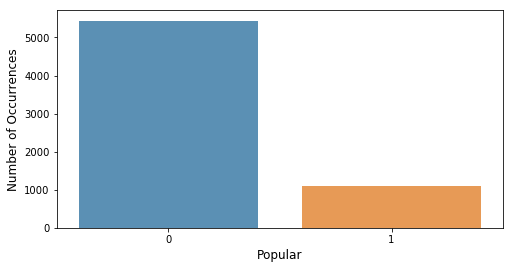

In [17]:
cnt_srs = train['Popular'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Popular', fontsize=12)

### As the classes are imbalanced, we will use StratifiedKFold instead of KFold while validation.

### After cleaning Snippet and HeadLine, we will create TF-IDF and count word matrix respectively, to make some insights of the text data.

In [18]:
train['Snippet'].fillna('unavailable', inplace=True)
test['Snippet'].fillna('unavailable', inplace=True)

In [19]:
train['Snippet'] = train['Snippet'].apply(lambda x: (x).lower())
test['Snippet'] = test['Snippet'].apply(lambda x: (x).lower())

In [20]:
# function to clean the text
# adapted from a kaggle kernal
def cleanData(text):
        
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"[^A-Za-z0-9]", " ", text)

    return text

In [21]:
train['Snippet'] = train['Snippet'].apply(lambda x: cleanData(x))
test['Snippet'] = test['Snippet'].apply(lambda x: cleanData(x))

In [22]:
# function for stemming and lemmatizing the text

def cleanData2(text, stemming = False, lemmatize=False):
    txt = str(text)
    txt = re.sub(r'-', r'', txt)
    
   
    if stemming:
        st = EnglishStemmer()
        txt = " ".join([st.stem(w) for w in txt.split()])

    
    if lemmatize:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w) for w in txt.split()])
        
    return txt

In [23]:
train['Snippet'] = train['Snippet'].map(lambda x: cleanData2(x,  stemming = True, lemmatize=True))
test['Snippet'] = test['Snippet'].map(lambda x: cleanData2(x,  stemming = True, lemmatize=True))

### Let's us explore Headlines.

In [24]:
# Number of unique words in the text
train['num_unique_words'] = train['Headline'].apply(lambda x: len(set(str(x).split())))
test['num_unique_words'] = test['Headline'].apply(lambda x: len(set(str(x).split())))

# Number of characters in the text
train['num_chars'] = train['Headline'].apply(lambda x: len(str(x)))
test['num_chars'] = test['Headline'].apply(lambda x: len(str(x)))

# Number of stopwords in the text 
eng_stopwords = set(stopwords.words("english"))
train['num_stopwords'] = train['Headline'].apply(lambda x: len([w for w in str(x).split() if w in eng_stopwords]))
test['num_stopwords'] = test['Headline'].apply(lambda x: len([w for w in str(x).split() if w in eng_stopwords]))

# Number of punctuations in the text
train['num_punctuations'] = train['Headline'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test['num_punctuations'] = test['Headline'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

# Average length of the words in the text
train['mean_word_len'] = train['Headline'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_len'] = test['Headline'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [25]:
# Fit transform the tfidf vectorizer

tfidf_vec = TfidfVectorizer(analyzer='char',stop_words='english', max_features=1000, ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train['Snippet'].values.tolist() + test['Snippet'].values.tolist())
train_tfidf = tfidf_vec.transform(train['Snippet'].values.tolist())
test_tfidf = tfidf_vec.transform(test['Snippet'].values.tolist())

In [26]:
n_comp = 50
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train, train_svd], axis=1)
test_df = pd.concat([test, test_svd], axis=1)

In [27]:
for i in train_svd.columns:
    train_df[i] = round(train_df[i], 4)
    test_df[i] = round(test_df[i], 4)
    
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd    

In [28]:
train['Headline'] = train['Headline'].map(lambda x: re.sub(r"[^A-Za-z]", " ", x))
test['Headline'] = test['Headline'].map(lambda x: re.sub(r"[^A-Za-z]", " ", x))

In [29]:
# Fit transform the count vectorizer
count_vec = CountVectorizer(stop_words='english', analyzer='word', min_df=0.01, ngram_range=(1,3))
count_vec.fit(train['Headline'].values.tolist() + test['Headline'].values.tolist())
train_count = count_vec.transform(train['Headline'].values.tolist())
test_count = count_vec.transform(test['Headline'].values.tolist())

In [30]:
train_count = pd.DataFrame(train_count.A, columns=count_vec.get_feature_names())
test_count = pd.DataFrame(test_count.A, columns=count_vec.get_feature_names())

In [31]:
train_df = pd.concat([train_df, train_count], axis=1)
test_df = pd.concat([test_df, test_count], axis=1)

In [32]:
train_df.columns = train_df.columns.str.replace('\s+', '_')
test_df.columns = test_df.columns.str.replace('\s+', '_')

In [33]:
train_df.head()

,NewsDesk,SectionName,SubsectionName,Headline,Snippet,WordCount,PubDate,Popular,UniqueID,Month,Weekday,Hour,HeadLine_n,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,svd_word_8,svd_word_9,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19,svd_word_20,svd_word_21,svd_word_22,svd_word_23,svd_word_24,svd_word_25,svd_word_26,svd_word_27,svd_word_28,svd_word_29,svd_word_30,svd_word_31,svd_word_32,svd_word_33,svd_word_34,svd_word_35,svd_word_36,svd_word_37,svd_word_38,svd_word_39,svd_word_40,svd_word_41,svd_word_42,svd_word_43,svd_word_44,svd_word_45,svd_word_46,svd_word_47,svd_word_48,svd_word_49,big,billion,business,china,daily,day,deal,ebola,fashion,fashion_week,million,morning,new,new_york,new_york_today,news,obama,paris,pictures,politics,report,says,small,spring,spring_summer,summer,test,today,week,word,york,york_today
0,Business,Crosswords/Games,Unknown,More School Daze,a puzzl from ethan cooper that remind me that ...,508,2014-09-01 22:00:09,1,1,9,0,22,0,3,16,0,0,4.666667,0.6179,-0.0183,-0.0439,-0.0037,0.0245,0.0398,0.0723,0.0667,-0.0225,-0.0516,0.1326,-0.0202,0.0614,0.0037,-0.0851,-0.0820,-0.0373,-0.0244,0.0134,-0.0635,0.0033,0.0453,-0.0286,-0.0023,0.0553,0.0591,-0.0226,0.0919,-0.0025,-0.0226,0.0326,-0.0198,-0.0166,-0.1179,-0.0402,-0.0344,0.0258,0.0741,0.0218,0.1542,0.0021,-0.0611,-0.0483,0.0072,-0.0327,-0.0027,0.1137,-0.0649,-0.0768,0.0508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Culture,Arts,Unknown,New 96-Page Murakami Work Coming in December,the strang librari will arriv just three and a...,285,2014-09-01 21:14:07,0,2,9,0,21,0,7,44,1,1,5.428571,0.7489,0.0058,-0.0423,0.0001,0.1064,0.0159,-0.0735,-0.0085,0.0660,-0.0362,0.0184,-0.0968,0.0924,-0.0020,-0.0532,-0.0235,0.0114,-0.0821,-0.0137,0.0454,-0.0783,-0.1023,-0.0218,-0.0113,0.0387,-0.1031,0.0461,-0.0548,-0.0960,0.0560,-0.0915,-0.0616,0.0151,0.0007,-0.0988,0.0318,0.0782,-0.0205,-0.0079,0.0928,-0.0908,0.0271,0.0492,-0.0172,-0.0245,0.0238,-0.0937,0.0228,-0.0461,-0.0377,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Business,Business Day,Dealbook,Public Pension Funds Stay Mum on Corporate Expats,public pension fund have major stake in americ...,1211,2014-09-01 21:05:36,0,3,9,0,21,0,8,49,1,0,5.250000,0.7755,-0.1017,-0.1037,-0.0359,-0.0205,-0.0621,0.0145,0.0155,-0.0092,-0.0863,0.0821,-0.0149,-0.0046,-0.0101,-0.0020,0.0416,-0.0059,-0.0123,-0.0256,-0.0024,0.0752,0.0532,-0.0509,-0.0487,0.0599,-0.0716,0.1369,-0.0027,-0.0638,-0.0694,0.1234,0.0477,-0.0084,-0.0179,0.0432,0.0364,0.0197,-0.0588,0.0557,-0.0374,0.0206,-0.0218,0.0523,0.0009,-0.0775,-0.0381,-0.0176,0.0339,-0.0008,0.0742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Business,Business Day,Dealbook,Boot Camp for Bankers,a they struggl to find new busi to bolster slu...,1405,2014-09-01 20:43:34,1,4,9,0,20,0,4,21,1,0,4.500000,0.7251,0.0172,-0.0855,0.0488,0.0298,-0.0177,-0.0255,-0.0524,0.0064,-0.0008,-0.0021,0.1270,0.0282,-0.0194,0.0387,-0.0484,0.0857,-0.0109,-0.0509,-0.0787,0.0608,0.0194,0.0158,0.0394,-0.0761,-0.0777,0.0722,0.0312,-0.0725,0.0054,0.0303,0.0290,0.0328,0.0061,0.1023,0.1025,0.0919,-0.0259,-0.0532,0.0059,-0.1129,-0.0415,-0.0014,0.0306,-0.0135,0.0656,-0.0004,-0.0596,-0.0037,0.0181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Science,Health,Unknown,Of Little Help to Older Knees,middl age and older patient are unlik to benef...,181,2014-09-01 18:58:51,1,5,9,0,18,0,6,29,1,0,4.000000,0.8294,0.0691,0.0382,-0.0370,0.0033,0.0789,-0.0046,-0.0685,0.0280,-0.0341,-0.0207,0.0635,-0.0142,-0.0746,0.0230,0.0249,0.0550,-0.0428,0.0352,-0.0516,0.0096,-0.0348,0.0547,0.0226,0.0498,-0.0115,0.0277,0.0382,0.0683,-0.0089,-0.0438,-0.0392,0.0091,-0.0255,0.0120,-0.0175,-0.0694,-0.0120,0.0295,0.0062,-0.0090,-0.0194,-0.0379,-0.0181,0.0222,0.0883,-0.0211,0.0097,0.0070,-0.0329,0,0,0,0,0

### Creating train_X, train_y, test_X:

In [34]:
train_X = train_df.drop(['SectionName', 'SubsectionName', 'Headline', 'Snippet', 'PubDate', 'Popular', 'UniqueID'], 1)
test_X = test_df.drop(['SectionName', 'SubsectionName', 'Headline', 'Snippet', 'PubDate', 'UniqueID'], 1)
train_y = train_df['Popular']

### One Hot encoding NewsDesk

In [35]:
cat_features=['NewsDesk']

for i in cat_features:
    dummies=pd.get_dummies(train_X[i], drop_first=False)
    train_X[dummies.columns]=dummies    
    dummies=pd.get_dummies(test_X[i], drop_first=False)
    test_X[dummies.columns]=dummies

In [36]:
train_X.drop(['NewsDesk'], 1, inplace=True)
test_X.drop(['NewsDesk'], 1, inplace=True)

In [37]:
train_X.head()

,WordCount,Month,Weekday,Hour,HeadLine_n,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,svd_word_8,svd_word_9,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19,svd_word_20,svd_word_21,svd_word_22,svd_word_23,svd_word_24,svd_word_25,svd_word_26,svd_word_27,svd_word_28,svd_word_29,svd_word_30,svd_word_31,svd_word_32,svd_word_33,svd_word_34,svd_word_35,svd_word_36,svd_word_37,svd_word_38,svd_word_39,svd_word_40,svd_word_41,svd_word_42,svd_word_43,svd_word_44,svd_word_45,svd_word_46,svd_word_47,svd_word_48,svd_word_49,big,billion,business,china,daily,day,deal,ebola,fashion,fashion_week,million,morning,new,new_york,new_york_today,news,obama,paris,pictures,politics,report,says,small,spring,spring_summer,summer,test,today,week,word,york,york_today,Business,Culture,Foreign,Magazine,Metro,OpEd,Science,Styles,TStyle,Travel,Unknown
0,508,9,0,22,0,3,16,0,0,4.666667,0.6179,-0.0183,-0.0439,-0.0037,0.0245,0.0398,0.0723,0.0667,-0.0225,-0.0516,0.1326,-0.0202,0.0614,0.0037,-0.0851,-0.0820,-0.0373,-0.0244,0.0134,-0.0635,0.0033,0.0453,-0.0286,-0.0023,0.0553,0.0591,-0.0226,0.0919,-0.0025,-0.0226,0.0326,-0.0198,-0.0166,-0.1179,-0.0402,-0.0344,0.0258,0.0741,0.0218,0.1542,0.0021,-0.0611,-0.0483,0.0072,-0.0327,-0.0027,0.1137,-0.0649,-0.0768,0.0508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,285,9,0,21,0,7,44,1,1,5.428571,0.7489,0.0058,-0.0423,0.0001,0.1064,0.0159,-0.0735,-0.0085,0.0660,-0.0362,0.0184,-0.0968,0.0924,-0.0020,-0.0532,-0.0235,0.0114,-0.0821,-0.0137,0.0454,-0.0783,-0.1023,-0.0218,-0.0113,0.0387,-0.1031,0.0461,-0.0548,-0.0960,0.0560,-0.0915,-0.0616,0.0151,0.0007,-0.0988,0.0318,0.0782,-0.0205,-0.0079,0.0928,-0.0908,0.0271,0.0492,-0.0172,-0.0245,0.0238,-0.0937,0.0228,-0.0461,-0.0377,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1211,9,0,21,0,8,49,1,0,5.250000,0.7755,-0.1017,-0.1037,-0.0359,-0.0205,-0.0621,0.0145,0.0155,-0.0092,-0.0863,0.0821,-0.0149,-0.0046,-0.0101,-0.0020,0.0416,-0.0059,-0.0123,-0.0256,-0.0024,0.0752,0.0532,-0.0509,-0.0487,0.0599,-0.0716,0.1369,-0.0027,-0.0638,-0.0694,0.1234,0.0477,-0.0084,-0.0179,0.0432,0.0364,0.0197,-0.0588,0.0557,-0.0374,0.0206,-0.0218,0.0523,0.0009,-0.0775,-0.0381,-0.0176,0.0339,-0.0008,0.0742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,1405,9,0,20,0,4,21,1,0,4.500000,0.7251,0.0172,-0.0855,0.0488,0.0298,-0.0177,-0.0255,-0.0524,0.0064,-0.0008,-0.0021,0.1270,0.0282,-0.0194,0.0387,-0.0484,0.0857,-0.0109,-0.0509,-0.0787,0.0608,0.0194,0.0158,0.0394,-0.0761,-0.0777,0.0722,0.0312,-0.0725,0.0054,0.0303,0.0290,0.0328,0.0061,0.1023,0.1025,0.0919,-0.0259,-0.0532,0.0059,-0.1129,-0.0415,-0.0014,0.0306,-0.0135,0.0656,-0.0004,-0.0596,-0.0037,0.0181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,181,9,0,18,0,6,29,1,0,4.000000,0.8294,0.0691,0.0382,-0.0370,0.0033,0.0789,-0.0046,-0.0685,0.0280,-0.0341,-0.0207,0.0635,-0.0142,-0.0746,0.0230,0.0249,0.0550,-0.0428,0.0352,-0.0516,0.0096,-0.0348,0.0547,0.0226,0.0498,-0.0115,0.0277,0.0382,0.0683,-0.0089,-0.0438,-0.0392,0.0091,-0.0255,0.0120,-0.0175,-0.0694,-0.0120,0.0295,0.0062,-0.0090,-0.0194,-0.0379,-0.0181,0.0222,0.0883,-0.0211,0.0097,0.0070,-0.0329,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [38]:
len(test_X.columns)

103

In [39]:
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i,feat))
    outfile.close()

def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, feature_names=None, seed_val=0, rounds=500, dep=5, eta=0.1):
    params = {}
    params["objective"] = "binary:logistic"
    params['eval_metric'] = 'auc'
    params["eta"] = eta
    params["subsample"] = 1
    params["min_child_weight"] = 1
    params["colsample_bytree"] = 0.7
    params["max_depth"] = dep
    params["silent"] = 1
    params["seed"] = seed_val
    num_rounds = rounds

    plst = list(params.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    if feature_names is not None:
        create_feature_map(feature_names)
        model.dump_model('xgbmodel.txt', 'xgb.fmap', with_stats=True)
        importance = model.get_fscore(fmap='xgb.fmap')
        importance = sorted(importance.items(), key=operator.itemgetter(1), reverse=True)
        imp_df = pd.DataFrame(importance, columns=['feature','fscore'])
        imp_df['fscore'] = imp_df['fscore'] / imp_df['fscore'].sum()
        imp_df.to_csv("imp_feat.txt", index=False)

    pred_test_y = model.predict(xgtest, ntree_limit=model.best_ntree_limit)
    pred_test_y2 = model.predict(xgb.DMatrix(test_X2), ntree_limit=model.best_ntree_limit)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        return pred_test_y, loss, pred_test_y2
    else:
        return pred_test_y, loss, pred_test_y2

In [40]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, feature_names=None, seed_val=0, rounds=500, dep=8, eta=0.05):
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
    params["max_depth"] = dep
    params["min_data_in_leaf"] = 128
    params["learning_rate"] = eta
    params["bagging_fraction"] = 1
    params["feature_fraction"] = 0.7
    params["bagging_freq"] = 1
    params["bagging_seed"] = seed_val
    params["verbosity"] = 0
    num_rounds = rounds

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=100, verbose_eval=20)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return pred_test_y, loss, pred_test_y2
    else:
        return pred_test_y, loss, pred_test_y2

In [41]:
def runRF(train_X, train_y, test_X, test_y=None, test_X2=None, depth=10, leaf=5, feat=0.3):
    model = RandomForestClassifier(n_estimators = 4000,
                                   criterion = 'gini',
                                   max_depth = depth,
                                   min_samples_split = 2,
                                   min_samples_leaf = leaf,
                                   max_features =  feat,
                                   n_jobs = -1,
                                   random_state = 0)
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]   
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth, leaf, feat : ", depth, leaf, feat)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [42]:
def runET(train_X, train_y, test_X, test_y=None, test_X2=None, depth=10, leaf=5, feat=0.7):
    model = ensemble.ExtraTreesClassifier(
                                        n_estimators = 500,
                                        criterion = 'gini',
                                        max_depth = depth,
                                        min_samples_split = 10,
                                        min_samples_leaf = leaf,
                                        max_features =  feat,
                                        #min_impurity_split = 0.1,
                                        n_jobs = -1,
                                        random_state = 0)
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth, leaf, feat : ", depth, leaf, feat)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [43]:
def runGBM(train_X, train_y, test_X, test_y=None, test_X2=None, depth=6, leaf=5, feat=0.7):
    model = GradientBoostingClassifier(n_estimators=3000,
                                       learning_rate=0.05,
                                       max_depth=depth,
                                       max_features=feat,
                                       min_samples_leaf=leaf,
                                       random_state=0)
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]   
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth, leaf, feat : ", depth, leaf, feat)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [44]:
def runCatB(train_X, train_y, test_X, test_y=None, test_X2=None, depth=6):
    model = CatBoostClassifier(
                                iterations = 500,
                                learning_rate = 0.05,
                                depth = depth,
                                od_type='Iter',
                                od_wait=100,
                                l2_leaf_reg=6,
                                eval_metric = 'AUC', 
                                verbose=False,
                                random_seed=0)
    
    model.fit(train_X, train_y, eval_set=(test_X, test_y))#, plot=True)
    train_preds = model.predict_proba(train_X)[:,1]
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth : ", depth)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [45]:
def runADA(train_X, train_y, test_X, test_y=None, test_X2=None, depth=4):
    model = AdaBoostClassifier(
                                DecisionTreeClassifier(max_depth=depth, max_features=0.7, min_samples_leaf=5),
                                n_estimators = 20,
                                learning_rate = 0.05,
                                random_state=0)
    
    model.fit(train_X, train_y)
    train_preds = model.predict_proba(train_X)[:,1]
    test_preds = model.predict_proba(test_X)[:,1]
    test_preds2 = model.predict_proba(test_X2)[:,1]
    test_loss = 0
    if test_y is not None:
        train_loss = metrics.roc_auc_score(train_y, train_preds)
        test_loss = metrics.roc_auc_score(test_y, test_preds)
        print("Depth : ", depth)
        print("Train and Test loss : ", train_loss, test_loss)
    return test_preds, test_loss, test_preds2

In [48]:
results = pd.DataFrame(index=range(7), columns=['Model', 'AUC Score'])
k=0
col=[]
val_pred=pd.DataFrame()
test_pred=pd.DataFrame()
for model_name in ['XGB', 'LGM', 'RF', 'ET', 'GBM', 'CatBoost', 'ADA']:
    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
    cv_scores = []
    pred_test_full = 0
    pred_val_full = np.zeros(train_X.shape[0])
    for dev_index, val_index in kf.split(train_X):
        dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]

        if model_name=='XGB':
            pred_val, loss, pred_test = runXGB(dev_X, dev_y, val_X, val_y, test_X, rounds=5000, feature_names=dev_X.columns.tolist())
        elif model_name=='LGM':
            pred_val, loss, pred_test = runLGB(dev_X, dev_y, val_X, val_y, test_X, rounds=5000)
        elif model_name=='RF':
            pred_val, loss, pred_test = runRF(dev_X, dev_y, val_X, val_y, test_X)
        elif model_name=='ET':
            pred_val, loss, pred_test = runET(dev_X, dev_y, val_X, val_y, test_X)
        elif model_name=='GBM':
            pred_val, loss, pred_test = runGBM(dev_X, dev_y, val_X, val_y, test_X)    
        elif model_name=='CatBoost':
            pred_val, loss, pred_test = runCatB(dev_X, dev_y, val_X, val_y, test_X)
        elif model_name=='ADA':
            pred_val, loss, pred_test = runADA(dev_X, dev_y, val_X, val_y, test_X)
            
        pred_val_full[val_index] = pred_val
        pred_test_full = pred_test_full + pred_test
        cv_scores.append(loss)
        print(cv_scores)
    pred_test_full /= 5.
    col.append(model_name)
    val_pred=pd.concat([val_pred, pd.DataFrame(pred_val_full)], axis=1)
    test_pred=pd.concat([test_pred, pd.DataFrame(pred_test_full)], axis=1)
    val_pred.columns=col
    test_pred.columns=col
    print(metrics.roc_auc_score(train_y, pred_val_full))
    results['Model'][k]=model_name
    results['AUC Score'][k]=metrics.roc_auc_score(train_y, pred_val_full)
    k=k+1

[0]	train-auc:0.809886	test-auc:0.794498
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.948201	test-auc:0.925631
[40]	train-auc:0.964688	test-auc:0.936046
[60]	train-auc:0.978386	test-auc:0.937988
[80]	train-auc:0.988609	test-auc:0.938989
[100]	train-auc:0.993826	test-auc:0.939817
[120]	train-auc:0.996651	test-auc:0.940547
[140]	train-auc:0.998577	test-auc:0.940624
[160]	train-auc:0.999482	test-auc:0.940838
[180]	train-auc:0.999798	test-auc:0.939441
[200]	train-auc:0.999918	test-auc:0.939017
[220]	train-auc:0.999978	test-auc:0.938501
[240]	train-auc:0.999996	test-auc:0.93798
Stopping. Best iteration:
[148]	train-auc:0.998925	test-auc:0.941541

[0.94154051108150649]
[0]	train-auc:0.813615	test-auc:0.772047
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 100 rounds.
[20]	train-auc:0.950169	test-au

Depth, leaf, feat :  6 5 0.7
Train and Test loss :  0.999999737335 0.913189759849
[0.93208590690727067, 0.93003857197218676, 0.93488750338845217, 0.92237413502055343, 0.91318975984889372]
0.925767562286


/home/dj/anaconda3/lib/python3.6/site-packages/catboost/core.py:1240: FutureWarning: The 'verbose' parameter is deprecated, use 'logging_level' parameter instead (posible values: 'Silent', 'Verbose', 'Info', 'Debug').
  super(CatBoostClassifier, self).__init__(params)


0: learn: 0.7401085	test: 0.7400509	bestTest: 0.7400509 (0)	total: 178ms	remaining: 1m 28s
1: learn: 0.8084422	test: 0.8073089	bestTest: 0.8073089 (1)	total: 389ms	remaining: 1m 36s
2: learn: 0.8773635	test: 0.8699043	bestTest: 0.8699043 (2)	total: 622ms	remaining: 1m 43s
3: learn: 0.8793504	test: 0.8744863	bestTest: 0.8744863 (3)	total: 823ms	remaining: 1m 42s
4: learn: 0.8836232	test: 0.872813	bestTest: 0.8744863 (3)	total: 1.01s	remaining: 1m 40s
5: learn: 0.8852035	test: 0.875871	bestTest: 0.875871 (5)	total: 1.2s	remaining: 1m 38s
6: learn: 0.8938797	test: 0.8836301	bestTest: 0.8836301 (6)	total: 1.4s	remaining: 1m 38s
7: learn: 0.8999016	test: 0.8900246	bestTest: 0.8900246 (7)	total: 1.58s	remaining: 1m 36s
8: learn: 0.9011211	test: 0.8907755	bestTest: 0.8907755 (8)	total: 1.78s	remaining: 1m 36s
9: learn: 0.9036984	test: 0.894328	bestTest: 0.894328 (9)	total: 1.95s	remaining: 1m 35s
10: learn: 0.9094376	test: 0.9003209	bestTest: 0.9003209 (10)	total: 2.17s	remaining: 1m 36s
11: 

89: learn: 0.9476002	test: 0.9338258	bestTest: 0.9338541 (88)	total: 18s	remaining: 1m 22s
90: learn: 0.9477158	test: 0.9339914	bestTest: 0.9339914 (90)	total: 18.2s	remaining: 1m 21s
91: learn: 0.9478935	test: 0.9339227	bestTest: 0.9339914 (90)	total: 18.4s	remaining: 1m 21s
92: learn: 0.9480619	test: 0.9340075	bestTest: 0.9340075 (92)	total: 18.6s	remaining: 1m 21s
93: learn: 0.9481581	test: 0.9341125	bestTest: 0.9341125 (93)	total: 18.8s	remaining: 1m 21s
94: learn: 0.9482774	test: 0.9339752	bestTest: 0.9341125 (93)	total: 19s	remaining: 1m 21s
95: learn: 0.9484854	test: 0.9340681	bestTest: 0.9341125 (93)	total: 19.2s	remaining: 1m 20s
96: learn: 0.9488453	test: 0.9343466	bestTest: 0.9343466 (96)	total: 19.4s	remaining: 1m 20s
97: learn: 0.9489853	test: 0.9343264	bestTest: 0.9343466 (96)	total: 19.6s	remaining: 1m 20s
98: learn: 0.949396	test: 0.9339389	bestTest: 0.9343466 (96)	total: 19.9s	remaining: 1m 20s
99: learn: 0.9496274	test: 0.9339792	bestTest: 0.9343466 (96)	total: 20.1s	

177: learn: 0.9672485	test: 0.9364337	bestTest: 0.936462 (176)	total: 36.8s	remaining: 1m 6s
178: learn: 0.9675099	test: 0.9364983	bestTest: 0.9364983 (178)	total: 37.1s	remaining: 1m 6s
179: learn: 0.9677022	test: 0.9366558	bestTest: 0.9366558 (179)	total: 37.3s	remaining: 1m 6s
180: learn: 0.967903	test: 0.9367728	bestTest: 0.9367728 (180)	total: 37.5s	remaining: 1m 6s
181: learn: 0.9681132	test: 0.9368294	bestTest: 0.9368294 (181)	total: 37.7s	remaining: 1m 5s
182: learn: 0.9682999	test: 0.9370191	bestTest: 0.9370191 (182)	total: 37.9s	remaining: 1m 5s
183: learn: 0.9684357	test: 0.9370514	bestTest: 0.9370514 (183)	total: 38s	remaining: 1m 5s
184: learn: 0.9687069	test: 0.9368536	bestTest: 0.9370514 (183)	total: 38.2s	remaining: 1m 5s
185: learn: 0.9688394	test: 0.9369141	bestTest: 0.9370514 (183)	total: 38.5s	remaining: 1m 4s
186: learn: 0.9689925	test: 0.9367204	bestTest: 0.9370514 (183)	total: 38.7s	remaining: 1m 4s
187: learn: 0.9691742	test: 0.9367769	bestTest: 0.9370514 (183)	

265: learn: 0.9828292	test: 0.9361511	bestTest: 0.9370514 (183)	total: 55.5s	remaining: 48.8s
266: learn: 0.9829551	test: 0.9362359	bestTest: 0.9370514 (183)	total: 55.7s	remaining: 48.6s
267: learn: 0.9830319	test: 0.9360987	bestTest: 0.9370514 (183)	total: 55.8s	remaining: 48.3s
268: learn: 0.9831363	test: 0.9361915	bestTest: 0.9370514 (183)	total: 56s	remaining: 48.1s
269: learn: 0.9832648	test: 0.9362723	bestTest: 0.9370514 (183)	total: 56.2s	remaining: 47.9s
270: learn: 0.9834136	test: 0.9363368	bestTest: 0.9370514 (183)	total: 56.5s	remaining: 47.7s
271: learn: 0.9834715	test: 0.9363005	bestTest: 0.9370514 (183)	total: 56.7s	remaining: 47.5s
272: learn: 0.9834901	test: 0.9362561	bestTest: 0.9370514 (183)	total: 56.9s	remaining: 47.3s
273: learn: 0.98362	test: 0.936244	bestTest: 0.9370514 (183)	total: 57.1s	remaining: 47.1s
274: learn: 0.9837722	test: 0.936248	bestTest: 0.9370514 (183)	total: 57.3s	remaining: 46.9s
275: learn: 0.9838625	test: 0.9361511	bestTest: 0.9370514 (183)	to

67: learn: 0.9409199	test: 0.9239328	bestTest: 0.9243479 (55)	total: 16.1s	remaining: 1m 42s
68: learn: 0.9411102	test: 0.9240712	bestTest: 0.9243479 (55)	total: 16.3s	remaining: 1m 41s
69: learn: 0.941378	test: 0.9239328	bestTest: 0.9243479 (55)	total: 16.5s	remaining: 1m 41s
70: learn: 0.9417278	test: 0.924123	bestTest: 0.9243479 (55)	total: 16.7s	remaining: 1m 41s
71: learn: 0.9418709	test: 0.9239501	bestTest: 0.9243479 (55)	total: 17s	remaining: 1m 40s
72: learn: 0.9421361	test: 0.9241922	bestTest: 0.9243479 (55)	total: 17.2s	remaining: 1m 40s
73: learn: 0.9424029	test: 0.9242052	bestTest: 0.9243479 (55)	total: 17.4s	remaining: 1m 39s
74: learn: 0.9427282	test: 0.9241922	bestTest: 0.9243479 (55)	total: 17.5s	remaining: 1m 39s
75: learn: 0.9430713	test: 0.9249144	bestTest: 0.9249144 (75)	total: 17.9s	remaining: 1m 39s
76: learn: 0.9434099	test: 0.9251306	bestTest: 0.9251306 (76)	total: 18.1s	remaining: 1m 39s
77: learn: 0.9435425	test: 0.9251695	bestTest: 0.9251695 (77)	total: 18.3s

155: learn: 0.9614439	test: 0.9327585	bestTest: 0.9327628 (154)	total: 36s	remaining: 1m 19s
156: learn: 0.9615831	test: 0.9328969	bestTest: 0.9328969 (156)	total: 36.2s	remaining: 1m 19s
157: learn: 0.9617413	test: 0.9328147	bestTest: 0.9328969 (156)	total: 36.3s	remaining: 1m 18s
158: learn: 0.961847	test: 0.9329012	bestTest: 0.9329012 (158)	total: 36.5s	remaining: 1m 18s
159: learn: 0.9620086	test: 0.9327628	bestTest: 0.9329012 (158)	total: 36.7s	remaining: 1m 18s
160: learn: 0.9623715	test: 0.9324731	bestTest: 0.9329012 (158)	total: 37.1s	remaining: 1m 18s
161: learn: 0.9625861	test: 0.9324774	bestTest: 0.9329012 (158)	total: 37.3s	remaining: 1m 17s
162: learn: 0.9627806	test: 0.9325682	bestTest: 0.9329012 (158)	total: 37.5s	remaining: 1m 17s
163: learn: 0.9629474	test: 0.932499	bestTest: 0.9329012 (158)	total: 37.7s	remaining: 1m 17s
164: learn: 0.9630482	test: 0.9325682	bestTest: 0.9329012 (158)	total: 37.9s	remaining: 1m 17s
165: learn: 0.963216	test: 0.9327196	bestTest: 0.93290

329: learn: 0.9872895	test: 0.9331693	bestTest: 0.9338914 (260)	total: 1m 17s	remaining: 39.9s
330: learn: 0.9873607	test: 0.9332861	bestTest: 0.9338914 (260)	total: 1m 17s	remaining: 39.6s
331: learn: 0.9874195	test: 0.9334158	bestTest: 0.9338914 (260)	total: 1m 17s	remaining: 39.4s
332: learn: 0.9875931	test: 0.9334244	bestTest: 0.9338914 (260)	total: 1m 18s	remaining: 39.1s
333: learn: 0.9877941	test: 0.9334288	bestTest: 0.9338914 (260)	total: 1m 18s	remaining: 38.9s
334: learn: 0.9879847	test: 0.9334461	bestTest: 0.9338914 (260)	total: 1m 18s	remaining: 38.7s
335: learn: 0.9880518	test: 0.9335585	bestTest: 0.9338914 (260)	total: 1m 18s	remaining: 38.5s
336: learn: 0.9882032	test: 0.9336104	bestTest: 0.9338914 (260)	total: 1m 19s	remaining: 38.2s
337: learn: 0.9883089	test: 0.9335239	bestTest: 0.9338914 (260)	total: 1m 19s	remaining: 38s
338: learn: 0.9883687	test: 0.9334504	bestTest: 0.9338914 (260)	total: 1m 19s	remaining: 37.7s
339: learn: 0.9884499	test: 0.9334763	bestTest: 0.93

55: learn: 0.9356846	test: 0.9335405	bestTest: 0.9335405 (55)	total: 14.1s	remaining: 1m 51s
56: learn: 0.9362951	test: 0.9338074	bestTest: 0.9338074 (56)	total: 14.3s	remaining: 1m 50s
57: learn: 0.9366344	test: 0.9342119	bestTest: 0.9342119 (57)	total: 14.5s	remaining: 1m 50s
58: learn: 0.9371172	test: 0.9343495	bestTest: 0.9343495 (58)	total: 14.7s	remaining: 1m 49s
59: learn: 0.937104	test: 0.9343454	bestTest: 0.9343495 (58)	total: 14.9s	remaining: 1m 49s
60: learn: 0.9375755	test: 0.9343495	bestTest: 0.9343495 (60)	total: 15.1s	remaining: 1m 48s
61: learn: 0.938029	test: 0.9348333	bestTest: 0.9348333 (61)	total: 15.3s	remaining: 1m 48s
62: learn: 0.9380764	test: 0.9344955	bestTest: 0.9348333 (61)	total: 15.5s	remaining: 1m 47s
63: learn: 0.9384352	test: 0.9344037	bestTest: 0.9348333 (61)	total: 15.8s	remaining: 1m 47s
64: learn: 0.938732	test: 0.934679	bestTest: 0.9348333 (61)	total: 16s	remaining: 1m 46s
65: learn: 0.9390241	test: 0.9346957	bestTest: 0.9348333 (61)	total: 16.2s	r

143: learn: 0.9563446	test: 0.937836	bestTest: 0.9383948 (138)	total: 33.2s	remaining: 1m 21s
144: learn: 0.9565305	test: 0.9377234	bestTest: 0.9383948 (138)	total: 33.4s	remaining: 1m 21s
145: learn: 0.9568318	test: 0.9379027	bestTest: 0.9383948 (138)	total: 33.6s	remaining: 1m 21s
146: learn: 0.9572098	test: 0.9377651	bestTest: 0.9383948 (138)	total: 33.9s	remaining: 1m 21s
147: learn: 0.9574166	test: 0.9379152	bestTest: 0.9383948 (138)	total: 34.1s	remaining: 1m 21s
148: learn: 0.9575059	test: 0.9378443	bestTest: 0.9383948 (138)	total: 34.3s	remaining: 1m 20s
149: learn: 0.9577345	test: 0.9379611	bestTest: 0.9383948 (138)	total: 34.4s	remaining: 1m 20s
150: learn: 0.9579049	test: 0.9378652	bestTest: 0.9383948 (138)	total: 34.6s	remaining: 1m 19s
151: learn: 0.9579734	test: 0.937861	bestTest: 0.9383948 (138)	total: 34.7s	remaining: 1m 19s
152: learn: 0.9582549	test: 0.9377984	bestTest: 0.9383948 (138)	total: 35.1s	remaining: 1m 19s
153: learn: 0.9584417	test: 0.93769	bestTest: 0.9383

77: learn: 0.9457728	test: 0.9295904	bestTest: 0.9296419 (74)	total: 17.6s	remaining: 1m 35s
78: learn: 0.9460687	test: 0.9296462	bestTest: 0.9296462 (78)	total: 17.8s	remaining: 1m 35s
79: learn: 0.9462259	test: 0.9298008	bestTest: 0.9298008 (79)	total: 18.1s	remaining: 1m 34s
80: learn: 0.9463409	test: 0.9297321	bestTest: 0.9298008 (79)	total: 18.3s	remaining: 1m 34s
81: learn: 0.9465977	test: 0.9296118	bestTest: 0.9298008 (79)	total: 18.5s	remaining: 1m 34s
82: learn: 0.9467433	test: 0.9294873	bestTest: 0.9298008 (79)	total: 18.7s	remaining: 1m 33s
83: learn: 0.9469376	test: 0.929629	bestTest: 0.9298008 (79)	total: 18.9s	remaining: 1m 33s
84: learn: 0.947117	test: 0.9297364	bestTest: 0.9298008 (79)	total: 19.1s	remaining: 1m 33s
85: learn: 0.9471382	test: 0.9297793	bestTest: 0.9298008 (79)	total: 19.3s	remaining: 1m 32s
86: learn: 0.947151	test: 0.9298781	bestTest: 0.9298781 (86)	total: 19.5s	remaining: 1m 32s
87: learn: 0.9472877	test: 0.9301487	bestTest: 0.9301487 (87)	total: 19.7

165: learn: 0.9644226	test: 0.9313772	bestTest: 0.9317251 (153)	total: 38s	remaining: 1m 16s
166: learn: 0.9645936	test: 0.9312527	bestTest: 0.9317251 (153)	total: 38.2s	remaining: 1m 16s
167: learn: 0.9648255	test: 0.9311625	bestTest: 0.9317251 (153)	total: 38.6s	remaining: 1m 16s
168: learn: 0.9649777	test: 0.9312527	bestTest: 0.9317251 (153)	total: 38.9s	remaining: 1m 16s
169: learn: 0.9652829	test: 0.93136	bestTest: 0.9317251 (153)	total: 39.3s	remaining: 1m 16s
170: learn: 0.9653451	test: 0.9312913	bestTest: 0.9317251 (153)	total: 39.6s	remaining: 1m 16s
171: learn: 0.9653969	test: 0.9313429	bestTest: 0.9317251 (153)	total: 40s	remaining: 1m 16s
172: learn: 0.9657318	test: 0.9313515	bestTest: 0.9317251 (153)	total: 40.4s	remaining: 1m 16s
173: learn: 0.9659951	test: 0.9314417	bestTest: 0.9317251 (153)	total: 40.7s	remaining: 1m 16s
174: learn: 0.9663627	test: 0.9314545	bestTest: 0.9317251 (153)	total: 40.9s	remaining: 1m 15s
175: learn: 0.9664645	test: 0.9312784	bestTest: 0.931725

253: learn: 0.9817651	test: 0.9313815	bestTest: 0.9321375 (210)	total: 59.7s	remaining: 57.9s
254: learn: 0.9819019	test: 0.9315233	bestTest: 0.9321375 (210)	total: 59.9s	remaining: 57.6s
255: learn: 0.9819332	test: 0.9314116	bestTest: 0.9321375 (210)	total: 1m	remaining: 57.3s
256: learn: 0.9820595	test: 0.9314116	bestTest: 0.9321375 (210)	total: 1m	remaining: 57.1s
257: learn: 0.9822331	test: 0.9312999	bestTest: 0.9321375 (210)	total: 1m	remaining: 57s
258: learn: 0.9823291	test: 0.9312999	bestTest: 0.9321375 (210)	total: 1m	remaining: 56.7s
259: learn: 0.9824585	test: 0.9311582	bestTest: 0.9321375 (210)	total: 1m 1s	remaining: 56.4s
260: learn: 0.9826183	test: 0.9310465	bestTest: 0.9321375 (210)	total: 1m 1s	remaining: 56.2s
261: learn: 0.9827072	test: 0.9310379	bestTest: 0.9321375 (210)	total: 1m 1s	remaining: 55.9s
262: learn: 0.9827728	test: 0.9310637	bestTest: 0.9321375 (210)	total: 1m 1s	remaining: 55.8s
263: learn: 0.9828552	test: 0.9311066	bestTest: 0.9321375 (210)	total: 1m 

27: learn: 0.9255795	test: 0.9062416	bestTest: 0.9077889 (21)	total: 6.53s	remaining: 1m 50s
28: learn: 0.9260037	test: 0.9068403	bestTest: 0.9077889 (21)	total: 6.75s	remaining: 1m 49s
29: learn: 0.9268386	test: 0.9078437	bestTest: 0.9078437 (29)	total: 6.96s	remaining: 1m 49s
30: learn: 0.9271987	test: 0.908455	bestTest: 0.908455 (30)	total: 7.21s	remaining: 1m 49s
31: learn: 0.9283719	test: 0.9087839	bestTest: 0.9087839 (31)	total: 7.42s	remaining: 1m 48s
32: learn: 0.9301951	test: 0.9099096	bestTest: 0.9099096 (32)	total: 7.62s	remaining: 1m 47s
33: learn: 0.9306947	test: 0.9099349	bestTest: 0.9099349 (33)	total: 7.82s	remaining: 1m 47s
34: learn: 0.9315095	test: 0.9110522	bestTest: 0.9110522 (34)	total: 8.02s	remaining: 1m 46s
35: learn: 0.9318764	test: 0.9108456	bestTest: 0.9110522 (34)	total: 8.21s	remaining: 1m 45s
36: learn: 0.931692	test: 0.9111407	bestTest: 0.9111407 (36)	total: 8.43s	remaining: 1m 45s
37: learn: 0.9321002	test: 0.9114485	bestTest: 0.9114485 (37)	total: 8.63

202: learn: 0.9718249	test: 0.9207514	bestTest: 0.9214934 (195)	total: 46.5s	remaining: 1m 8s
203: learn: 0.9720387	test: 0.9208231	bestTest: 0.9214934 (195)	total: 46.7s	remaining: 1m 7s
204: learn: 0.9720886	test: 0.9208652	bestTest: 0.9214934 (195)	total: 46.9s	remaining: 1m 7s
205: learn: 0.9721309	test: 0.9208484	bestTest: 0.9214934 (195)	total: 47.1s	remaining: 1m 7s
206: learn: 0.972261	test: 0.9207345	bestTest: 0.9214934 (195)	total: 47.3s	remaining: 1m 6s
207: learn: 0.9723639	test: 0.920958	bestTest: 0.9214934 (195)	total: 47.6s	remaining: 1m 6s
208: learn: 0.9725076	test: 0.9208526	bestTest: 0.9214934 (195)	total: 47.9s	remaining: 1m 6s
209: learn: 0.9726497	test: 0.9207936	bestTest: 0.9214934 (195)	total: 48.1s	remaining: 1m 6s
210: learn: 0.9727648	test: 0.9208399	bestTest: 0.9214934 (195)	total: 48.3s	remaining: 1m 6s
211: learn: 0.9729226	test: 0.9211372	bestTest: 0.9214934 (195)	total: 48.5s	remaining: 1m 5s
212: learn: 0.9731543	test: 0.9211498	bestTest: 0.9214934 (195

290: learn: 0.9842587	test: 0.9214703	bestTest: 0.9221996 (279)	total: 1m 7s	remaining: 48.6s
291: learn: 0.9843704	test: 0.9216178	bestTest: 0.9221996 (279)	total: 1m 7s	remaining: 48.3s
292: learn: 0.9844878	test: 0.9216431	bestTest: 0.9221996 (279)	total: 1m 8s	remaining: 48.1s
293: learn: 0.9846357	test: 0.9215504	bestTest: 0.9221996 (279)	total: 1m 8s	remaining: 47.8s
294: learn: 0.984803	test: 0.9215377	bestTest: 0.9221996 (279)	total: 1m 8s	remaining: 47.6s
295: learn: 0.9849012	test: 0.9215208	bestTest: 0.9221996 (279)	total: 1m 8s	remaining: 47.4s
296: learn: 0.9849966	test: 0.9215799	bestTest: 0.9221996 (279)	total: 1m 8s	remaining: 47.1s
297: learn: 0.9851612	test: 0.9214998	bestTest: 0.9221996 (279)	total: 1m 9s	remaining: 46.9s
298: learn: 0.9853614	test: 0.9213606	bestTest: 0.9221996 (279)	total: 1m 9s	remaining: 46.6s
299: learn: 0.98555	test: 0.9216684	bestTest: 0.9221996 (279)	total: 1m 9s	remaining: 46.4s
300: learn: 0.9856343	test: 0.921601	bestTest: 0.9221996 (279)	

377: learn: 0.9915298	test: 0.9223978	bestTest: 0.9223978 (377)	total: 1m 27s	remaining: 28.3s
378: learn: 0.9915682	test: 0.9225159	bestTest: 0.9225159 (378)	total: 1m 27s	remaining: 28.1s
379: learn: 0.9916191	test: 0.9222924	bestTest: 0.9225159 (378)	total: 1m 28s	remaining: 27.8s
380: learn: 0.9917229	test: 0.9223683	bestTest: 0.9225159 (378)	total: 1m 28s	remaining: 27.6s
381: learn: 0.9918353	test: 0.9222755	bestTest: 0.9225159 (378)	total: 1m 28s	remaining: 27.5s
382: learn: 0.9918781	test: 0.9222334	bestTest: 0.9225159 (378)	total: 1m 29s	remaining: 27.2s
383: learn: 0.9919262	test: 0.9223894	bestTest: 0.9225159 (378)	total: 1m 29s	remaining: 27s
384: learn: 0.9919498	test: 0.9224484	bestTest: 0.9225159 (378)	total: 1m 29s	remaining: 26.7s
385: learn: 0.9919929	test: 0.922305	bestTest: 0.9225159 (378)	total: 1m 29s	remaining: 26.5s
386: learn: 0.9920714	test: 0.9222924	bestTest: 0.9225159 (378)	total: 1m 30s	remaining: 26.3s
387: learn: 0.9920948	test: 0.9223093	bestTest: 0.922

464: learn: 0.9958283	test: 0.922811	bestTest: 0.9230007 (449)	total: 1m 50s	remaining: 8.33s
465: learn: 0.9958562	test: 0.9227688	bestTest: 0.9230007 (449)	total: 1m 50s	remaining: 8.1s
466: learn: 0.9958762	test: 0.92287	bestTest: 0.9230007 (449)	total: 1m 51s	remaining: 7.86s
467: learn: 0.9959158	test: 0.9227098	bestTest: 0.9230007 (449)	total: 1m 51s	remaining: 7.62s
468: learn: 0.9959479	test: 0.9227646	bestTest: 0.9230007 (449)	total: 1m 51s	remaining: 7.38s
469: learn: 0.9959747	test: 0.922908	bestTest: 0.9230007 (449)	total: 1m 51s	remaining: 7.14s
470: learn: 0.9960196	test: 0.9228152	bestTest: 0.9230007 (449)	total: 1m 52s	remaining: 6.91s
471: learn: 0.9960558	test: 0.9228321	bestTest: 0.9230007 (449)	total: 1m 52s	remaining: 6.67s
472: learn: 0.9960713	test: 0.922811	bestTest: 0.9230007 (449)	total: 1m 52s	remaining: 6.43s
473: learn: 0.9960957	test: 0.9228236	bestTest: 0.9230007 (449)	total: 1m 52s	remaining: 6.19s
474: learn: 0.9961076	test: 0.9228447	bestTest: 0.923000

### Here is the AUC Score of different Models after 5 fold validation.

In [49]:
results

,Model,AUC Score
0,XGB,0.93324
1,LGM,0.930231
2,RF,0.921697
3,ET,0.932845
4,GBM,0.925768
5,CatBoost,0.931087
6,ADA,0.912807


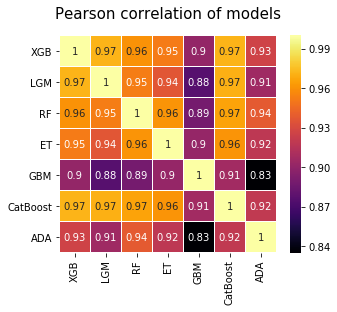

In [50]:
colormap = plt.cm.inferno
plt.figure(figsize=(5,4))
plt.title('Pearson correlation of models', y=1.05, size=15)
sns.heatmap(val_pred.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

### Stacked features

In [51]:
val_pred.head()

,XGB,LGM,RF,ET,GBM,CatBoost,ADA
0,0.832048,0.752154,0.608718,0.837137,0.999919,0.907250,0.900318
1,0.017489,0.022661,0.050609,0.055215,0.000035,0.042757,0.077963
2,0.354413,0.275761,0.342044,0.339766,0.255743,0.372176,0.379757
3,0.515671,0.525435,0.395509,0.547226,0.505415,0.719136,0.429593
4,0.081383,0.189498,0.308999,0.413539,0.000155,0.162091,0.211363


In [52]:
test_pred.head()

,XGB,LGM,RF,ET,GBM,CatBoost,ADA
0,0.059163,0.092373,0.166431,0.097764,0.000837,0.069220,0.117189
1,0.216935,0.178788,0.237388,0.163089,0.003734,0.175610,0.276045
2,0.785677,0.745813,0.685817,0.839882,0.998999,0.905409,0.800867
3,0.369769,0.391663,0.343349,0.262103,0.276918,0.391067,0.361976
4,0.174140,0.208168,0.334155,0.348642,0.134111,0.178297,0.276260


### Now let's ensemble these Stacked features using XGBoost

In [53]:
train_X=pd.concat([train_X, val_pred], 1)
test_X=pd.concat([test_X, test_pred], 1)

In [54]:
train_X.head()

,WordCount,Month,Weekday,Hour,HeadLine_n,num_unique_words,num_chars,num_stopwords,num_punctuations,mean_word_len,svd_word_0,svd_word_1,svd_word_2,svd_word_3,svd_word_4,svd_word_5,svd_word_6,svd_word_7,svd_word_8,svd_word_9,svd_word_10,svd_word_11,svd_word_12,svd_word_13,svd_word_14,svd_word_15,svd_word_16,svd_word_17,svd_word_18,svd_word_19,svd_word_20,svd_word_21,svd_word_22,svd_word_23,svd_word_24,svd_word_25,svd_word_26,svd_word_27,svd_word_28,svd_word_29,svd_word_30,svd_word_31,svd_word_32,svd_word_33,svd_word_34,svd_word_35,svd_word_36,svd_word_37,svd_word_38,svd_word_39,svd_word_40,svd_word_41,svd_word_42,svd_word_43,svd_word_44,svd_word_45,svd_word_46,svd_word_47,svd_word_48,svd_word_49,big,billion,business,china,daily,day,deal,ebola,fashion,fashion_week,million,morning,new,new_york,new_york_today,news,obama,paris,pictures,politics,report,says,small,spring,spring_summer,summer,test,today,week,word,york,york_today,Business,Culture,Foreign,Magazine,Metro,OpEd,Science,Styles,TStyle,Travel,Unknown,XGB,LGM,RF,ET,GBM,CatBoost,ADA
0,508,9,0,22,0,3,16,0,0,4.666667,0.6179,-0.0183,-0.0439,-0.0037,0.0245,0.0398,0.0723,0.0667,-0.0225,-0.0516,0.1326,-0.0202,0.0614,0.0037,-0.0851,-0.0820,-0.0373,-0.0244,0.0134,-0.0635,0.0033,0.0453,-0.0286,-0.0023,0.0553,0.0591,-0.0226,0.0919,-0.0025,-0.0226,0.0326,-0.0198,-0.0166,-0.1179,-0.0402,-0.0344,0.0258,0.0741,0.0218,0.1542,0.0021,-0.0611,-0.0483,0.0072,-0.0327,-0.0027,0.1137,-0.0649,-0.0768,0.0508,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.832048,0.752154,0.608718,0.837137,0.999919,0.907250,0.900318
1,285,9,0,21,0,7,44,1,1,5.428571,0.7489,0.0058,-0.0423,0.0001,0.1064,0.0159,-0.0735,-0.0085,0.0660,-0.0362,0.0184,-0.0968,0.0924,-0.0020,-0.0532,-0.0235,0.0114,-0.0821,-0.0137,0.0454,-0.0783,-0.1023,-0.0218,-0.0113,0.0387,-0.1031,0.0461,-0.0548,-0.0960,0.0560,-0.0915,-0.0616,0.0151,0.0007,-0.0988,0.0318,0.0782,-0.0205,-0.0079,0.0928,-0.0908,0.0271,0.0492,-0.0172,-0.0245,0.0238,-0.0937,0.0228,-0.0461,-0.0377,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.017489,0.022661,0.050609,0.055215,0.000035,0.042757,0.077963
2,1211,9,0,21,0,8,49,1,0,5.250000,0.7755,-0.1017,-0.1037,-0.0359,-0.0205,-0.0621,0.0145,0.0155,-0.0092,-0.0863,0.0821,-0.0149,-0.0046,-0.0101,-0.0020,0.0416,-0.0059,-0.0123,-0.0256,-0.0024,0.0752,0.0532,-0.0509,-0.0487,0.0599,-0.0716,0.1369,-0.0027,-0.0638,-0.0694,0.1234,0.0477,-0.0084,-0.0179,0.0432,0.0364,0.0197,-0.0588,0.0557,-0.0374,0.0206,-0.0218,0.0523,0.0009,-0.0775,-0.0381,-0.0176,0.0339,-0.0008,0.0742,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.354413,0.275761,0.342044,0.339766,0.255743,0.372176,0.379757
3,1405,9,0,20,0,4,21,1,0,4.500000,0.7251,0.0172,-0.0855,0.0488,0.0298,-0.0177,-0.0255,-0.0524,0.0064,-0.0008,-0.0021,0.1270,0.0282,-0.0194,0.0387,-0.0484,0.0857,-0.0109,-0.0509,-0.0787,0.0608,0.0194,0.0158,0.0394,-0.0761,-0.0777,0.0722,0.0312,-0.0725,0.0054,0.0303,0.0290,0.0328,0.0061,0.1023,0.1025,0.0919,-0.0259,-0.0532,0.0059,-0.1129,-0.0415,-0.0014,0.0306,-0.0135,0.0656,-0.0004,-0.0596,-0.0037,0.0181,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.515671,0.525435,0.395509,0.547226,0.505415,0.719136,0.429593
4,181,9,0,18,0,6,29,1,0,4.000000,0.8294,0.0691,0.0382,-0.0370,0.0033,0.0789,-0.0046,-0.0685,0.0280,-0.0341,-0.0207,0.0635,-0.0142,-0.0746,0.0230,0.0249,0.0550,-0.0428,0.0352,-0.0516,0.0096,-0.0348,0.0547,0.0226,0.0498,-0.0115,0.0277,0.0382,0.0683,-0.0089,-0.0438,-0.0392,0.0091,-0.0255,0.0120,-0.0175,-0.0694,-0.0120,0.0295,0.0062,-0.0090,-0.0194,-0.0379,-0.0181,0.0222,0.0883,-0.0211,0.0097,0.0070,-0.0329,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.081383,0.189498,0.308999,0.413539,0.000155,0.162091,0.211363


In [55]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
cv_scores = []
pred_test_full = 0
pred_val_full = np.zeros(train_X.shape[0])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val, loss, pred_test = runCatB(dev_X, dev_y, val_X, val_y, test_X)
    pred_val_full[val_index] = pred_val
    pred_test_full = pred_test_full + pred_test
    cv_scores.append(loss)
    print(cv_scores)
pred_test_full /= 5.
print(metrics.roc_auc_score(train_y, pred_val_full))

/home/dj/anaconda3/lib/python3.6/site-packages/catboost/core.py:1240: FutureWarning: The 'verbose' parameter is deprecated, use 'logging_level' parameter instead (posible values: 'Silent', 'Verbose', 'Info', 'Debug').
  super(CatBoostClassifier, self).__init__(params)


0: learn: 0.908123	test: 0.906766	bestTest: 0.906766 (0)	total: 136ms	remaining: 1m 7s
1: learn: 0.9162495	test: 0.916045	bestTest: 0.916045 (1)	total: 347ms	remaining: 1m 26s
2: learn: 0.918915	test: 0.9193795	bestTest: 0.9193795 (2)	total: 526ms	remaining: 1m 27s
3: learn: 0.9254325	test: 0.9280166	bestTest: 0.9280166 (3)	total: 715ms	remaining: 1m 28s
4: learn: 0.9267157	test: 0.9291107	bestTest: 0.9291107 (4)	total: 913ms	remaining: 1m 30s
5: learn: 0.9317588	test: 0.9366578	bestTest: 0.9366578 (5)	total: 1.13s	remaining: 1m 33s
6: learn: 0.9318499	test: 0.9369222	bestTest: 0.9369222 (6)	total: 1.34s	remaining: 1m 34s
7: learn: 0.9329464	test: 0.9387308	bestTest: 0.9387308 (7)	total: 1.55s	remaining: 1m 35s
8: learn: 0.9334433	test: 0.9399076	bestTest: 0.9399076 (8)	total: 1.76s	remaining: 1m 36s
9: learn: 0.9335713	test: 0.9392435	bestTest: 0.9399076 (8)	total: 2s	remaining: 1m 38s
10: learn: 0.9338374	test: 0.940063	bestTest: 0.940063 (10)	total: 2.21s	remaining: 1m 38s
11: learn

89: learn: 0.9527405	test: 0.9417747	bestTest: 0.9422187 (20)	total: 18.5s	remaining: 1m 24s
90: learn: 0.9531833	test: 0.9415405	bestTest: 0.9422187 (20)	total: 18.8s	remaining: 1m 24s
91: learn: 0.9534609	test: 0.9416051	bestTest: 0.9422187 (20)	total: 19s	remaining: 1m 24s
92: learn: 0.9536609	test: 0.9417343	bestTest: 0.9422187 (20)	total: 19.1s	remaining: 1m 23s
93: learn: 0.9537916	test: 0.9417262	bestTest: 0.9422187 (20)	total: 19.3s	remaining: 1m 23s
94: learn: 0.9539656	test: 0.941815	bestTest: 0.9422187 (20)	total: 19.5s	remaining: 1m 23s
95: learn: 0.9541675	test: 0.9416011	bestTest: 0.9422187 (20)	total: 19.8s	remaining: 1m 23s
96: learn: 0.9543479	test: 0.9416657	bestTest: 0.9422187 (20)	total: 20s	remaining: 1m 22s
97: learn: 0.9545448	test: 0.941702	bestTest: 0.9422187 (20)	total: 20.2s	remaining: 1m 22s
98: learn: 0.9546978	test: 0.9415688	bestTest: 0.9422187 (20)	total: 20.4s	remaining: 1m 22s
99: learn: 0.9550179	test: 0.9415688	bestTest: 0.9422187 (20)	total: 20.6s	r

54: learn: 0.9456461	test: 0.9363	bestTest: 0.9368406 (34)	total: 11.5s	remaining: 1m 32s
55: learn: 0.9457941	test: 0.9361617	bestTest: 0.9368406 (34)	total: 11.7s	remaining: 1m 32s
56: learn: 0.9459226	test: 0.936179	bestTest: 0.9368406 (34)	total: 11.9s	remaining: 1m 32s
57: learn: 0.9461017	test: 0.9363	bestTest: 0.9368406 (34)	total: 12.1s	remaining: 1m 32s
58: learn: 0.9463165	test: 0.9365898	bestTest: 0.9368406 (34)	total: 12.3s	remaining: 1m 32s
59: learn: 0.9467744	test: 0.9368233	bestTest: 0.9368406 (34)	total: 12.5s	remaining: 1m 31s
60: learn: 0.9468637	test: 0.9368492	bestTest: 0.9368492 (60)	total: 12.8s	remaining: 1m 31s
61: learn: 0.9470331	test: 0.9369184	bestTest: 0.9369184 (61)	total: 13s	remaining: 1m 31s
62: learn: 0.9473263	test: 0.9370611	bestTest: 0.9370611 (62)	total: 13.2s	remaining: 1m 31s
63: learn: 0.9476153	test: 0.9371951	bestTest: 0.9371951 (63)	total: 13.4s	remaining: 1m 31s
64: learn: 0.9478868	test: 0.9372081	bestTest: 0.9372081 (64)	total: 13.6s	rema

63: learn: 0.9473814	test: 0.942119	bestTest: 0.9427779 (43)	total: 14.8s	remaining: 1m 40s
64: learn: 0.9475265	test: 0.942144	bestTest: 0.9427779 (43)	total: 15.1s	remaining: 1m 41s
65: learn: 0.9476885	test: 0.9422566	bestTest: 0.9427779 (43)	total: 15.3s	remaining: 1m 40s
66: learn: 0.9477733	test: 0.9422941	bestTest: 0.9427779 (43)	total: 15.6s	remaining: 1m 40s
67: learn: 0.948078	test: 0.9422441	bestTest: 0.9427779 (43)	total: 15.8s	remaining: 1m 40s
68: learn: 0.9484021	test: 0.9423942	bestTest: 0.9427779 (43)	total: 16s	remaining: 1m 39s
69: learn: 0.9487804	test: 0.9426445	bestTest: 0.9427779 (43)	total: 16.4s	remaining: 1m 40s
70: learn: 0.9489247	test: 0.9426153	bestTest: 0.9427779 (43)	total: 16.7s	remaining: 1m 40s
71: learn: 0.949137	test: 0.9427195	bestTest: 0.9427779 (43)	total: 17s	remaining: 1m 41s
72: learn: 0.9492197	test: 0.9425902	bestTest: 0.9427779 (43)	total: 17.4s	remaining: 1m 41s
73: learn: 0.9493709	test: 0.9424735	bestTest: 0.9427779 (43)	total: 17.8s	rem

151: learn: 0.9654293	test: 0.9427946	bestTest: 0.9429948 (131)	total: 35.8s	remaining: 1m 22s
152: learn: 0.9656348	test: 0.9427696	bestTest: 0.9429948 (131)	total: 36s	remaining: 1m 21s
153: learn: 0.9658813	test: 0.942828	bestTest: 0.9429948 (131)	total: 36.3s	remaining: 1m 21s
154: learn: 0.9661966	test: 0.942878	bestTest: 0.9429948 (131)	total: 36.5s	remaining: 1m 21s
155: learn: 0.966312	test: 0.9429531	bestTest: 0.9429948 (131)	total: 36.7s	remaining: 1m 20s
156: learn: 0.9665416	test: 0.9428029	bestTest: 0.9429948 (131)	total: 37s	remaining: 1m 20s
157: learn: 0.9667315	test: 0.9425902	bestTest: 0.9429948 (131)	total: 37.2s	remaining: 1m 20s
158: learn: 0.9670215	test: 0.9425819	bestTest: 0.9429948 (131)	total: 37.4s	remaining: 1m 20s
159: learn: 0.9673758	test: 0.9425277	bestTest: 0.9429948 (131)	total: 37.6s	remaining: 1m 19s
160: learn: 0.9675006	test: 0.9424151	bestTest: 0.9429948 (131)	total: 37.8s	remaining: 1m 19s
161: learn: 0.9676368	test: 0.9425277	bestTest: 0.9429948

3: learn: 0.9335149	test: 0.9122607	bestTest: 0.9122607 (3)	total: 781ms	remaining: 1m 36s
4: learn: 0.9367297	test: 0.9157507	bestTest: 0.9157507 (4)	total: 992ms	remaining: 1m 38s
5: learn: 0.9372758	test: 0.9186629	bestTest: 0.9186629 (5)	total: 1.18s	remaining: 1m 37s
6: learn: 0.9369475	test: 0.9194511	bestTest: 0.9194511 (6)	total: 1.37s	remaining: 1m 36s
7: learn: 0.937511	test: 0.9193846	bestTest: 0.9194511 (6)	total: 1.57s	remaining: 1m 36s
8: learn: 0.9379512	test: 0.9197454	bestTest: 0.9197454 (8)	total: 1.75s	remaining: 1m 35s
9: learn: 0.9381117	test: 0.9214828	bestTest: 0.9214828 (9)	total: 1.94s	remaining: 1m 35s
10: learn: 0.9385141	test: 0.9224214	bestTest: 0.9224214 (10)	total: 2.13s	remaining: 1m 34s
11: learn: 0.9386534	test: 0.9258426	bestTest: 0.9258426 (11)	total: 2.33s	remaining: 1m 34s
12: learn: 0.9385128	test: 0.9255914	bestTest: 0.9258426 (11)	total: 2.52s	remaining: 1m 34s
13: learn: 0.9386646	test: 0.9260553	bestTest: 0.9260553 (13)	total: 2.73s	remaining:

92: learn: 0.9557725	test: 0.9327045	bestTest: 0.9338599 (65)	total: 20.4s	remaining: 1m 29s
93: learn: 0.9559098	test: 0.9326143	bestTest: 0.9338599 (65)	total: 20.7s	remaining: 1m 29s
94: learn: 0.9560178	test: 0.9327389	bestTest: 0.9338599 (65)	total: 20.9s	remaining: 1m 29s
95: learn: 0.9562934	test: 0.932799	bestTest: 0.9338599 (65)	total: 21.1s	remaining: 1m 28s
96: learn: 0.9564785	test: 0.9326229	bestTest: 0.9338599 (65)	total: 21.3s	remaining: 1m 28s
97: learn: 0.9566874	test: 0.9326701	bestTest: 0.9338599 (65)	total: 21.5s	remaining: 1m 28s
98: learn: 0.9568812	test: 0.9327131	bestTest: 0.9338599 (65)	total: 21.9s	remaining: 1m 28s
99: learn: 0.9571029	test: 0.9324854	bestTest: 0.9338599 (65)	total: 22.1s	remaining: 1m 28s
100: learn: 0.9572985	test: 0.9325327	bestTest: 0.9338599 (65)	total: 22.3s	remaining: 1m 28s
101: learn: 0.9575098	test: 0.932464	bestTest: 0.9338599 (65)	total: 22.5s	remaining: 1m 27s
102: learn: 0.957782	test: 0.9325799	bestTest: 0.9338599 (65)	total: 2

12: learn: 0.9391897	test: 0.921114	bestTest: 0.9218518 (11)	total: 2.65s	remaining: 1m 39s
13: learn: 0.9393444	test: 0.9214049	bestTest: 0.9218518 (11)	total: 2.83s	remaining: 1m 38s
14: learn: 0.9393288	test: 0.9206945	bestTest: 0.9218518 (11)	total: 3.02s	remaining: 1m 37s
15: learn: 0.9394454	test: 0.9206734	bestTest: 0.9218518 (11)	total: 3.21s	remaining: 1m 37s
16: learn: 0.9399402	test: 0.9213438	bestTest: 0.9218518 (11)	total: 3.42s	remaining: 1m 37s
17: learn: 0.9403857	test: 0.9224863	bestTest: 0.9224863 (17)	total: 3.78s	remaining: 1m 41s
18: learn: 0.9406069	test: 0.9220436	bestTest: 0.9224863 (17)	total: 3.96s	remaining: 1m 40s
19: learn: 0.9413607	test: 0.9242318	bestTest: 0.9242318 (19)	total: 4.15s	remaining: 1m 39s
20: learn: 0.9416389	test: 0.9240758	bestTest: 0.9242318 (19)	total: 4.37s	remaining: 1m 39s
21: learn: 0.9420387	test: 0.9243077	bestTest: 0.9243077 (21)	total: 4.59s	remaining: 1m 39s
22: learn: 0.9423862	test: 0.9242276	bestTest: 0.9243077 (21)	total: 4.

101: learn: 0.9568895	test: 0.9249148	bestTest: 0.9264579 (51)	total: 23s	remaining: 1m 29s
102: learn: 0.9571306	test: 0.9250034	bestTest: 0.9264579 (51)	total: 23.2s	remaining: 1m 29s
103: learn: 0.9574808	test: 0.9246872	bestTest: 0.9264579 (51)	total: 23.5s	remaining: 1m 29s
104: learn: 0.9577193	test: 0.9247209	bestTest: 0.9264579 (51)	total: 23.7s	remaining: 1m 29s
105: learn: 0.9579113	test: 0.9246281	bestTest: 0.9264579 (51)	total: 24.1s	remaining: 1m 29s
106: learn: 0.9579651	test: 0.9247504	bestTest: 0.9264579 (51)	total: 24.3s	remaining: 1m 29s
107: learn: 0.9582669	test: 0.9249275	bestTest: 0.9264579 (51)	total: 24.5s	remaining: 1m 28s
108: learn: 0.9585004	test: 0.9249233	bestTest: 0.9264579 (51)	total: 24.6s	remaining: 1m 28s
109: learn: 0.9589102	test: 0.9246703	bestTest: 0.9264579 (51)	total: 24.8s	remaining: 1m 28s
110: learn: 0.9591403	test: 0.9244342	bestTest: 0.9264579 (51)	total: 25.2s	remaining: 1m 28s
111: learn: 0.959362	test: 0.9243962	bestTest: 0.9264579 (51)	

### Saving our predicted values.

In [56]:
sub = pd.DataFrame({'UniqueID':test['UniqueID']})
sub['Probability1'] = pred_test_full
sub.to_csv('Submission.csv', index=False)